In [130]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [131]:
# Load the data
df = pd.read_csv('../product_details.csv')
df

,ProductID,Description,Country,Category
0,23183,MOTHER'S KITCHEN SPOON REST,United Kingdom,Dapur
1,82578,KITCHEN METAL SIGN,United Kingdom,Dapur
2,47567,TEA TIME KITCHEN APRON,Portugal,Dapur
3,22624,IVORY KITCHEN SCALES,United Kingdom,Dapur
4,22625,RED KITCHEN SCALES,United Kingdom,Dapur
...,...,...,...,...
175,21995,Fujifilm Finepix 30i,United Kingdom,Kamera
176,21996,Fujifilm FinePix 3800,Norway,Kamera
177,21997,Fujifilm FinePix F10 Zoom,United Kingdom,Kamera
178,21998,Fujifilm FinePix F410 Zoom,United Kingdom,Kamera


In [132]:
# Dataset information
print("There are {} rows and {} columns".format(df.shape[0],df.shape[1]))
print("\n====================================================")
print("Missing Values:\n", df.isnull().sum())
print("\n====================================================")
print("Categories Counts:\n", df['Category'].value_counts())

There are 180 rows and 4 columns

Missing Values:
 ProductID      0
Description    0
Country        0
Category       0
dtype: int64

Categories Counts:
 Dapur           20
Cafe            20
Hobi            20
Elektronik      20
Travel          20
Baju            20
Musik           20
Transportasi    20
Kamera          20
Name: Category, dtype: int64


In [134]:
# Mapping the labels to numeric
df['Category'] = df['Category'].map({
    'Dapur': 0,
    'Cafe': 1,
    'Hobi': 2,
    'Elektronik': 3,
    'Travel': 4,
    'Baju': 5,
    'Musik': 6,
    'Transportasi': 7,
    'Kamera': 8
})

df

,ProductID,Description,Country,Category
0,23183,MOTHER'S KITCHEN SPOON REST,United Kingdom,0
1,82578,KITCHEN METAL SIGN,United Kingdom,0
2,47567,TEA TIME KITCHEN APRON,Portugal,0
3,22624,IVORY KITCHEN SCALES,United Kingdom,0
4,22625,RED KITCHEN SCALES,United Kingdom,0
...,...,...,...,...
175,21995,Fujifilm Finepix 30i,United Kingdom,8
176,21996,Fujifilm FinePix 3800,Norway,8
177,21997,Fujifilm FinePix F10 Zoom,United Kingdom,8
178,21998,Fujifilm FinePix F410 Zoom,United Kingdom,8


In [144]:
# Split the dataset into train and test sets
y = tf.keras.utils.to_categorical(df['Category'].values, num_classes=9)
X_train, X_test, Y_train, Y_test = train_test_split(df['Description'], y, test_size=0.2, random_state=24)

In [145]:
# Preprocessing the text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [146]:
word_index = tokenizer.word_index
print(len(word_index))
print(word_index)

465
{'<OOV>': 1, 'kitchen': 2, 'coffee': 3, 'black': 4, 'bike': 5, 'red': 6, 'blue': 7, 'set': 8, 'mug': 9, 'garden': 10, 'mountain': 11, 'with': 12, 'fujifilm': 13, 'silver': 14, 'women': 15, 'white': 16, 'guitar': 17, 'finepix': 18, 'yamaha': 19, 'canon': 20, 'box': 21, 'design': 22, 'fit': 23, 'casual': 24, 'shirt': 25, 'mini': 26, 'clock': 27, 'fashion': 28, 'powershot': 29, 'hd': 30, 'small': 31, 'men': 32, 'regular': 33, '2': 34, 'warmer': 35, 'vintage': 36, 'retrospot': 37, 'piano': 38, 'tv': 39, 'flower': 40, '3': 41, 'ivory': 42, '200': 43, '100': 44, 'retro': 45, 'wall': 46, 'pink': 47, 'neck': 48, 'scales': 49, 'rain': 50, 'electric': 51, 'wire': 52, 'hand': 53, 'smart': 54, 'alexa': 55, 'kit': 56, 'battery': 57, 'summer': 58, 'slipper': 59, '4k': 60, 'model': 61, 'tea': 62, 'pots': 63, 'plaque': 64, 'casio': 65, 'exilim': 66, 'ex': 67, 'chevrolet': 68, 'bass': 69, '46': 70, 'campus': 71, 'sutra': 72, 'checked': 73, 'backpack': 74, 'for': 75, 'metal': 76, 'sign': 77, 'made':

In [147]:
# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(X_train)
maxlen = max([len(x) for x in sequences])
padded = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [148]:
# Generate and pad the test sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [149]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=maxlen),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics='accuracy')

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("val_accuracy") > 0.85):
            self.model.stop_training = True

# Summary of the model
model.summary()

# Train the model
history = model.fit(padded, Y_train, validation_data=(test_padded, Y_test), callbacks=myCallback(), epochs=100)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 21, 100)           46600     
                                                                 
 conv1d_32 (Conv1D)          (None, 19, 64)            19264     
                                                                 
 bidirectional_32 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_99 (Dense)            (None, 512)               66048     
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_100 (Dense)           (None, 512)               262656    
                                                     

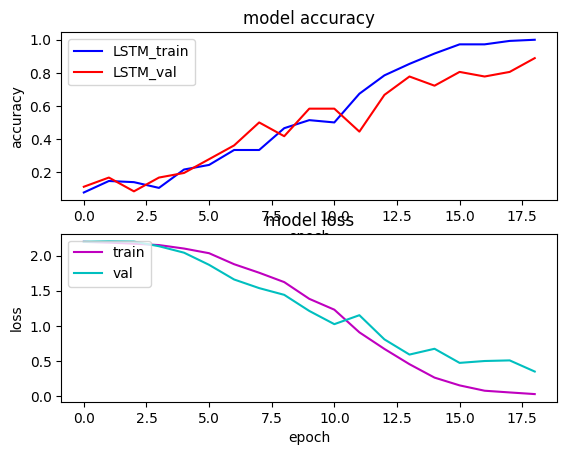

In [150]:
import matplotlib.pyplot as plt

s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [151]:
scores = model.predict(test_padded).round()
print(scores)

2/2 [==============================] - 1s 11ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1

In [152]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n\n",confusion_matrix(Y_test.argmax(axis=1),scores.argmax(axis=1)))
print("\n")
print("Classification Report:\n\n",classification_report(Y_test.argmax(axis=1), scores.argmax(axis=1)))

Confusion Matrix:

 [[5 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0]
 [0 0 3 0 1 0 0 0 0]
 [0 0 1 5 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 1 0 4 0 0 0]
 [0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 1 4]]


Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       0.75      0.75      0.75         4
           3       0.83      0.83      0.83         6
           4       0.75      1.00      0.86         3
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         2
           7       0.75      1.00      0.86         3
           8       1.00      0.80      0.89         5

    accuracy                           0.89        36
   macro avg       0.90      0.91      0.90        36
weighted avg       0.90      0.89      0.89        36

